In [1]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [3]:
# --- Data preparation (same as before) ---

top_dir = '/kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset'

# Define the training paths
train_dir = os.path.join(top_dir, 'train')

# List all directories in the train directory
all_directories = os.listdir(train_dir)

# Initialize lists to store directories for human-drawn and AI-generated images
train_human = []
train_ai = []

In [4]:
for directory in all_directories:
    if not directory.startswith('AI_'):
        train_human.append(os.path.join(train_dir, directory))
    else:
        train_ai.append(os.path.join(train_dir, directory))

print("Train directories containing human-drawn images:")
for i, directory in enumerate(train_human):
    print(f"{i}. {directory}")

print("\nTrain directories containing AI-generated images:")
for i, directory in enumerate(train_ai):
    print(f"{i}. {directory}")

Train directories containing human-drawn images:
0. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/impressionism
1. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/renaissance
2. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/surrealism
3. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/art_nouveau
4. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/baroque
5. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/expressionism
6. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/romanticism
7. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/ukiyo_e
8. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/post_impressionism
9. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/realism

Train directories containing AI-generated images:
0. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/AI_SD_impressionism
1. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/train/AI_LD_post_impressionism
2. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/tr

In [5]:
# Define the test paths
test_dir = os.path.join(top_dir, 'test')
all_directories = os.listdir(test_dir)

test_human = []
test_ai = []

for directory in all_directories:
    if not directory.startswith('AI_'):
        test_human.append(os.path.join(test_dir, directory))
    else:
        test_ai.append(os.path.join(test_dir, directory))

print("Test directories containing human-drawn images:")
for i, directory in enumerate(test_human):
    print(f"{i}. {directory}")

print("\nTest directories containing AI-generated images:")
for i, directory in enumerate(test_ai):
    print(f"{i}. {directory}")

Test directories containing human-drawn images:
0. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/impressionism
1. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/renaissance
2. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/surrealism
3. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/art_nouveau
4. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/baroque
5. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/expressionism
6. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/romanticism
7. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/ukiyo_e
8. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/post_impressionism
9. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/realism

Test directories containing AI-generated images:
0. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/AI_SD_impressionism
1. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/AI_LD_post_impressionism
2. /kaggle/input/real-ai-art/Real_AI_SD_LD_Dataset/test/AI_LD_art_n

In [6]:
# Function to plot k images from a given directory
def plot_im(directory, k):
    files = os.listdir(directory)
    im_files = random.choices(files, k=k)
    fig = plt.figure()
    for i in range(k):
        im_path = os.path.join(directory, im_files[i])
        im = cv2.cvtColor(cv2.imread(im_path), cv2.COLOR_BGR2RGB)
        ax = fig.add_subplot(int(np.sqrt(k)), int(np.sqrt(k)), i + 1)
        ax.imshow(im)
        ax.axis('off')
        ax.set_title(im_files[i], fontsize=8, pad=2)
    plt.tight_layout()
    plt.show()

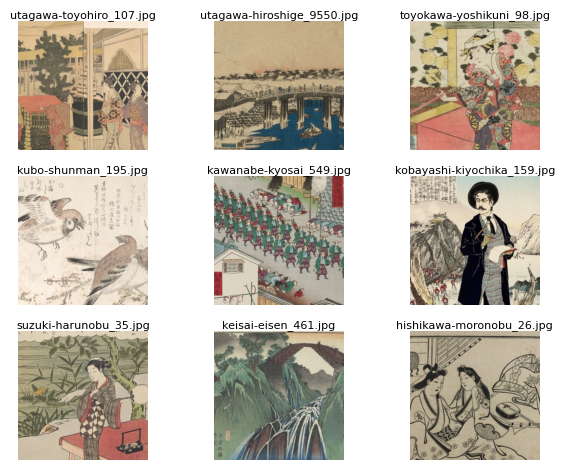

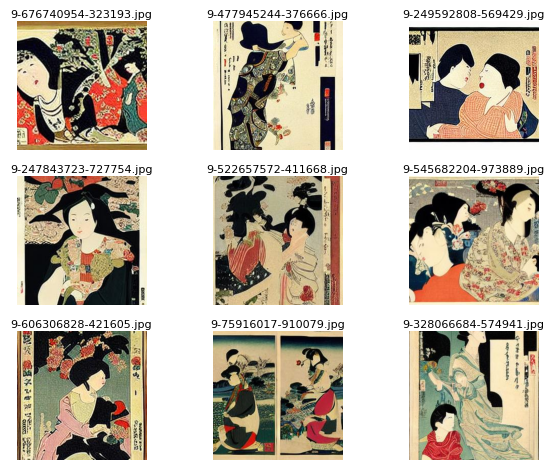

                                            filepath  label
0  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
1  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
2  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
3  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
4  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
Number of files under each label:
label
AI       105015
human     50000
Name: count, dtype: int64


In [7]:
# Example visualizations
plot_im(directory=train_human[7], k=9)
plot_im(directory=train_ai[4], k=9)

# Build the training DataFrame
filepaths = []
labels = []
train_data = pd.DataFrame(columns=['filepath', 'label'])
for directory in train_human:
    for file in os.listdir(directory):
        filepaths.append(os.path.join(directory, file))
        labels.append("human")
for directory in train_ai:
    for file in os.listdir(directory):
        filepaths.append(os.path.join(directory, file))
        labels.append("AI")
data = pd.DataFrame({'filepath': filepaths, 'label': labels})
train_data = pd.concat([train_data, data], ignore_index=True)

print(train_data.head())
print("Number of files under each label:")
print(train_data['label'].value_counts())

In [8]:
# Optionally drop extra samples to balance the classes
random_seed = 123
np.random.seed(random_seed)
num_to_drop = 55015
ai_indices = train_data[train_data['label'] == 'AI'].index
indices_to_drop = np.random.choice(ai_indices, num_to_drop, replace=False)
train_data = train_data.drop(indices_to_drop).reset_index(drop=True)
print(train_data.head())
print("\nNumber of files under each label:")
print(train_data['label'].value_counts())

                                            filepath  label
0  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
1  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
2  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
3  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
4  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human

Number of files under each label:
label
human    50000
AI       50000
Name: count, dtype: int64


In [9]:
# Build the test DataFrame
filepaths = []
labels = []
test_data = pd.DataFrame(columns=['filepath', 'label'])
for directory in test_human:
    for file in os.listdir(directory):
        filepaths.append(os.path.join(directory, file))
        labels.append("human")
for directory in test_ai:
    for file in os.listdir(directory):
        filepaths.append(os.path.join(directory, file))
        labels.append("AI")
data = pd.DataFrame({'filepath': filepaths, 'label': labels})
test_data = pd.concat([test_data, data], ignore_index=True)
print(test_data.head())
print("\nNumber of files under each label:")
print(test_data['label'].value_counts())

                                            filepath  label
0  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
1  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
2  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
3  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human
4  /kaggle/input/real-ai-art/Real_AI_SD_LD_Datase...  human

Number of files under each label:
label
AI       20000
human    10000
Name: count, dtype: int64


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img

In [11]:
# --- Data Generators ---
# Define image size for Swin Transformer (we use 224x224)
IMG_SIZE = (224, 224)

# Use augmentation for training data and simple rescaling for testing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    channel_shift_range=20.0,  # Random channel shift
    brightness_range=[0.5, 1.5],  # Random brightness change
)

In [12]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=64,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 80000 validated image filenames belonging to 2 classes.


In [13]:
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 20000 validated image filenames belonging to 2 classes.


In [14]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 30000 validated image filenames belonging to 2 classes.


In [15]:
print("Training classes:", train_generator.class_indices)
print("Test classes:", test_generator.class_indices)

Training classes: {'AI': 0, 'human': 1}
Test classes: {'AI': 0, 'human': 1}


In [16]:
import tensorflow as tf
import tensorflow_hub as hub

In [17]:
class ViTClassifier(tf.keras.Model):
    def __init__(self, vit_url, num_classes=2):
        super(ViTClassifier, self).__init__()
        self.rescaling = tf.keras.layers.Rescaling(1./255)
        self.vit_layer = hub.KerasLayer(vit_url, trainable=False, dtype=tf.float32)
        # Remove GlobalAveragePooling2D since the ViT output is already flat.
        # self.pooling = tf.keras.layers.GlobalAveragePooling2D()
        self.dense = tf.keras.layers.Dense(256, activation='relu')
        self.dropout = tf.keras.layers.Dropout(0.3)
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')
    
    def call(self, inputs, training=False):
        x = self.rescaling(inputs)
        x = self.vit_layer(x, training=training)
        # x already has shape (None, 768); no need to pool.
        x = self.dense(x)
        x = self.dropout(x, training=training)
        return self.classifier(x)


In [18]:
# URL of the pre-trained Vision Transformer model on TF Hub
vit_feature_extractor_url = "https://tfhub.dev/sayakpaul/vit_b16_fe/1"

In [19]:
# Instantiate the custom model
model = ViTClassifier(vit_feature_extractor_url)

In [20]:
# Build the model by specifying the input shape (batch dimension can be None)
model.build((None, 224, 224, 3))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'vi_t_classifier', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [21]:
model.summary()

Model: "vi_t_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
# --- Callbacks ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Monitor val_loss for better convergence
checkpoint = ModelCheckpoint('best_model_vit.keras', monitor='val_accuracy', save_best_only=True)

In [24]:
# --- Train the model ---
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[early_stop, checkpoint],
    verbose=2
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 - 2152s - 2s/step - accuracy: 0.6688 - loss: 0.5838 - val_accuracy: 0.2837 - val_loss: 0.9702
Epoch 2/15
1250/1250 - 1565s - 1s/step - accuracy: 0.6887 - loss: 0.5601 - val_accuracy: 0.5179 - val_loss: 0.8230
Epoch 3/15
1250/1250 - 1566s - 1s/step - accuracy: 0.6943 - loss: 0.5541 - val_accuracy: 0.1760 - val_loss: 1.0287
Epoch 4/15
1250/1250 - 1565s - 1s/step - accuracy: 0.6992 - loss: 0.5491 - val_accuracy: 0.2749 - val_loss: 1.0076
Epoch 5/15
1250/1250 - 1580s - 1s/step - accuracy: 0.7033 - loss: 0.5455 - val_accuracy: 0.2520 - val_loss: 1.0204
Epoch 6/15
1250/1250 - 1565s - 1s/step - accuracy: 0.7034 - loss: 0.5438 - val_accuracy: 0.7018 - val_loss: 0.6997
Epoch 7/15
1250/1250 - 1569s - 1s/step - accuracy: 0.7085 - loss: 0.5419 - val_accuracy: 0.4785 - val_loss: 0.8857
Epoch 8/15
1250/1250 - 1571s - 1s/step - accuracy: 0.7067 - loss: 0.5428 - val_accuracy: 0.7141 - val_loss: 0.6731
Epoch 9/15
1250/1250 - 1559s - 1s/step - accuracy: 0.7065 - loss: 0.5398 - val_accuracy: 0.

In [28]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

469/469 - 337s - 719ms/step - accuracy: 0.7636 - loss: 0.4826
Test Loss: 0.4826461374759674
Test Accuracy: 0.7636333107948303


In [29]:
# Make predictions on the test set
predictions = model.predict(test_generator, verbose=2)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Convert true labels to class labels
true_labels = test_generator.classes

# Show a classification report
print(classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys()))

# Show a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)

469/469 - 162s - 345ms/step
              precision    recall  f1-score   support

          AI       0.85      0.79      0.82     20000
       human       0.63      0.71      0.67     10000

    accuracy                           0.76     30000
   macro avg       0.74      0.75      0.74     30000
weighted avg       0.77      0.76      0.77     30000

[[15808  4192]
 [ 2899  7101]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step


TypeError: 'dict_keys' object is not subscriptable

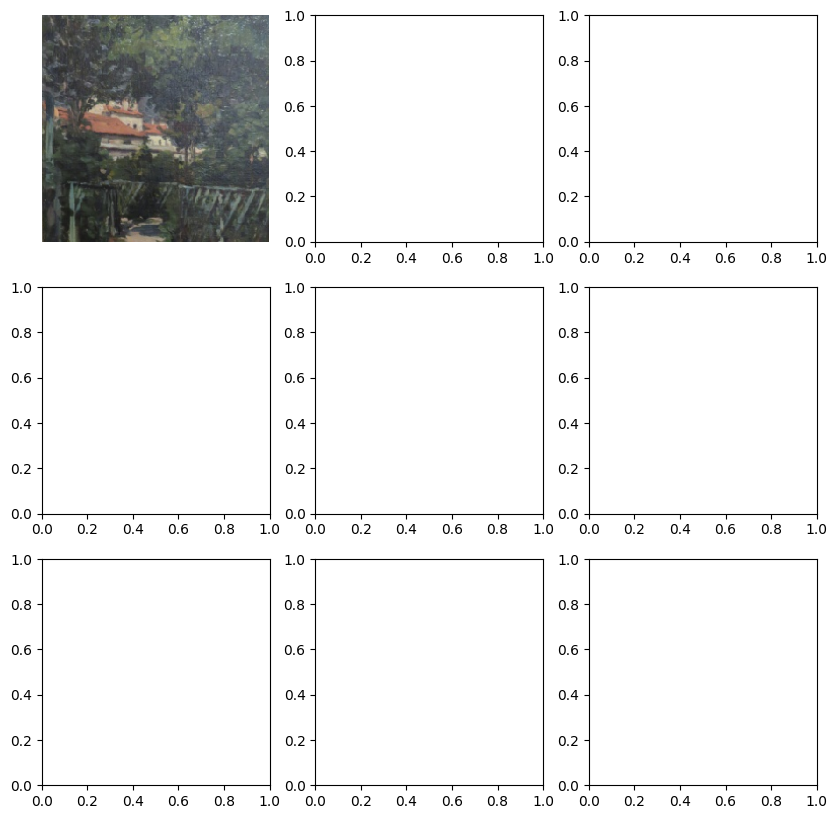

In [30]:
# Show some test images with predictions
import matplotlib.pyplot as plt

# Get a batch of images and predictions
images, labels = next(test_generator)
predictions = model.predict(images)

# Display a few images with their predicted labels
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis('off')
    true_label = test_generator.class_indices.keys()[labels[i]]
    predicted_label = test_generator.class_indices.keys()[np.argmax(predictions[i])]
    ax.set_title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10)
plt.tight_layout()
plt.show()

In [31]:
# Save the trained model
model.save('final_vit_model.keras')